In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
from scipy.fftpack import fft, fftshift
from sklearn.preprocessing import MinMaxScaler, normalize, scale
import librosa as li
import librosa.display
import glob

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Audio
np.seterr(divide='ignore', invalid='ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
path = glob.iglob('G:\ΣΧΟΛΗ p12127\Πτυχιακη\MAPS Dataset\Music Dataset\Validation Dataset\**\**\**\*.wav')
#inputfile='Alesis-Fusion-Nylon-String-Guitar-C4.wav'
inputfile=next(path)

In [3]:
'''We load the file using librosa. Data is stored, sample rate is sr.
We use pre emphasis on the data.
We specify which kind of window (small/big) we have and then we apply it.
We return the needed information for the rest of the preprocessing procedure.
framesize = nfft_length in this notebook they are the same value and ALWAYS SHOULD be.
'''
def extract(inputfile, small_window_size=True):

    data, sr = li.core.load(inputfile,sr=None,mono=True,offset=0.0,duration=300.0,dtype=float)
    pre_emphasis = 0.97
    data = np.append(data[0], data[1:] - pre_emphasis * data[:-1])
 
    if small_window_size==True:
        window_size=0.04645
        nfft_length = int(window_size*sr)
    else:
        window_size=0.04645*4
        nfft_length = int(window_size*sr-1)
    
    all_frames_length = len(data)
    window_hop_length = 0.01
    #window_size = 0.04645
    overlap = int(sr*window_hop_length)
    number_of_frames = int(all_frames_length/overlap)
    
    return data, sr, nfft_length, number_of_frames

data, sr, nfft_length, number_of_frames = extract(inputfile, small_window_size=True)
print("Data: ", len(data), "\nSample rate: ", sr ,"\nframe size: ", nfft_length, "\nnumber of frames: ", number_of_frames)

'We load the file using librosa. Data is stored, sample rate is sr.\nWe use pre emphasis on the data.\nWe specify which kind of window (small/big) we have and then we apply it.\nWe return the needed information for the rest of the preprocessing procedure.\nframesize = nfft_length in this notebook they are the same value and ALWAYS SHOULD be.\n'

Data:  5620807 
Sample rate:  44100 
frame size:  2048 
number of frames:  12745


In [4]:
'''Create chuncks of the data according to window of fft. small = 2048, big = 4*2048.'''
def create_frames(data, nfft_length, number_of_frames):
    frames = np.ndarray((number_of_frames, nfft_length))
    overlap=441
    for k in range(number_of_frames):
        for i in range(nfft_length):
            if((k*overlap+i)<int(len(data))):
                frames[k][i] = data[k*overlap+i]
    return frames

frames = create_frames(data, nfft_length, number_of_frames)
print(frames.shape)

'Create chuncks of the data according to window of fft. small = 2048, big = 4*2048.'

(12745, 2048)


In [5]:
'''We use all the above information we extracted and we get the magnitude frames.
First apply Hamming window to time-domain frames. Then FFT them, keep only the real part.
Then the power frames that are the energies of the FFT.
Then we create the bins we need to store the 88 possible notes. '''
def spectrogram(frames, nfft_length, sr):
    
    '''Hertz vocabulary.'''
    hz_notes = np.zeros(90)
    hz_notes[-1] = sr/2
    for i in range(88):
        hz_notes[i+1] = (2**((i-48)/12) * 440)
    #print("Frequencies of notes that split the filterbanks: \n", hz_notes)
    
    ''' Hamming window applied before FFT.'''
    ham = signal.hamming(nfft_length)
    #plt.xlabel('Samples')
    #plt.ylabel('Amplitude')
    #plt.plot(ham)
    
    for i in range(0, frames.shape[0]):
        frames[i] *= ham
    
    # Magnitude of frames (simple fft appliance)
    '''To apply logarithmic characteristics of sound intensity,
    a log-like compression with a multiplication factor 1000 is
    applied on the magnitude of spectrograms
    ''' 
    mag_frames = np.abs(np.fft.rfft(frames, nfft_length))
    #mag_frames = 10e3*np.log10(mag_frames)
    # Power Spectrum of frames.
    pow_frames = ((1.0 / nfft_length) * ((mag_frames) ** 2))  # Power Spectrum
    
    nfilt = 88 # number of filters we need to have the 88 notes of the midipiano
    high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(0, high_freq_mel, 88 + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    binz = np.floor((nfft_length+1) * hz_points / sr)

    # fb stands for filterbank:
    fb = np.zeros((nfilt, int(np.floor(nfft_length/2 +1))))
    for i in range(1, nfilt + 1): 
        filter_left = int(binz[i-1])
        filter_center = int(binz[i])
        filter_right = int(binz[i+1])
        
        for k in range(filter_left, filter_center):
            fb[i-1, k] = (k -binz[i-1]) / (binz[i] - binz[i-1])
        for k in range(filter_center, filter_right):
            fb[i-1, k] = (binz[i+1]- k) / (binz[i+1] - binz[i])
        
    filterbanks = np.dot(pow_frames, fb.T)
    #filterbanks = 20 * np.log10(filterbanks)  # dB
    
    
    '''Use local maxima as second method to get the loudest notes:''' 
 #   maxm = signal.argrelextrema(filterbanks, np.greater, axis=0, order=1)
 #   x = np.array(maxm[0])
 #   y = np.array(maxm[1])
 #   fb = np.zeros((filterbanks.shape[0], filterbanks.shape[1]))
 #   for i in range(x.size):
 #       fb[x[i],y[i]]=1
        
        
        
    ''' Allow this to run when trying to normalize! And disable local Maxima.'''
    
    
    fb = normalize(filterbanks) #, axis=0
    # Get the negative values of filterbanks to equal 0.
    for i in range(fb.shape[0]):
        for j in range(fb.shape[1]):
            if fb[i,j] < 0:
                fb[i,j] = 0
    #filterbanks = np.where(filterbanks==0, np.finfo(float).eps, filterbanks)
    
    
    
    return(fb)


filterbanks = spectrogram(frames, nfft_length, sr)
filterbanks.shape

'We use all the above information we extracted and we get the magnitude frames.\nFirst apply Hamming window to time-domain frames. Then FFT them, keep only the real part.\nThen the power frames that are the energies of the FFT.\nThen we create the bins we need to store the 88 possible notes. '

(12745, 88)

In [6]:
'''ZERO_PAD: We get the number of frames that the wave file has.
We use mod to get the remainder that divides with 0 remainder from 50. 
50 is the FPS we need for each batch, so we need to just zero pad this far.
We return the frames which contain the values of the frames, and the
total_frames which is equal to the number of frames, after the zero pad is done.
Frames are in time domain, NOT in frequency domain.
'''
def zero_pad(filterbanks):
    overlap=441
    divider, remainder = np.divmod(filterbanks.shape[0] , 50)
    zero_frames = 50 - remainder# +1 # +1 because we later get the 1st order diff. therefore we need +1 frames.
    frames = np.ndarray((zero_frames, 88))
    filterbanks = np.concatenate((filterbanks, frames), axis=0)
    
    '''Not properly working.'''
    return filterbanks

'ZERO_PAD: We get the number of frames that the wave file has.\nWe use mod to get the remainder that divides with 0 remainder from 50. \n50 is the FPS we need for each batch, so we need to just zero pad this far.\nWe return the frames which contain the values of the frames, and the\ntotal_frames which is equal to the number of frames, after the zero pad is done.\nFrames are in time domain, NOT in frequency domain.\n'

'Must get the 1st order difference between the frames, not the banks.\nWe compute the 1st order difference to get another spectrogram.\nIn the paper, it suggests it works better than the pure energies in the filterbanks.\nThe 1st order diff : Get the difference, and then normalise (-1,1)\n'

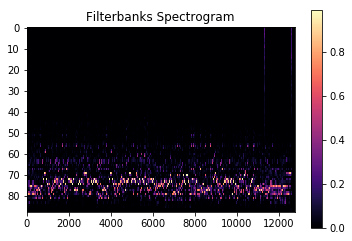

In [30]:
'''Must get the 1st order difference between the frames, not the banks.
We compute the 1st order difference to get another spectrogram.
In the paper, it suggests it works better than the pure energies in the filterbanks.
The 1st order diff : Get the difference, and then normalise (-1,1)
'''
def firdif(fb):
    banks = np.diff(fb, axis=0)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(banks)
    banks = scaler.transform(banks)
    
    plt.figure()
    plt.imshow(np.flipud(banks.T),cmap="magma", aspect=88)
    plt.title('First Difference Between Frames')
    plt.colorbar()
    

#firdif(filterbanks)

def wave_plot(filterbanks):
    plt.figure()
    plt.imshow(np.flipud(filterbanks.T),cmap="magma",  aspect=100) #magma
    plt.title("Filterbanks Spectrogram")
    plt.colorbar()
    
wave_plot(filterbanks)

## Final output for preprocessing!
window_size can have another value

In [25]:
'''Finally, we gather all the functions we created above, uniting them in one, so it is easy to call it
    on another file. We just need the path and which of the 2 windows we would like to compute, and returns
    the first order difference of the filterbanks.'''
def process(inputfile, small_window_size):
    data, sr, nfft_length, number_of_frames = extract(inputfile=inputfile, small_window_size=small_window_size)
    frames = create_frames(data, nfft_length, number_of_frames)
    filterbanks = spectrogram(frames, nfft_length, sr)
    ''' Try without the differences, since we dont concatenate input with the dif. 
    Try to train with just the banks as it is.'''
    return (np.flipud(filterbanks.T))

'Finally, we gather all the functions we created above, uniting them in one, so it is easy to call it\n    on another file. We just need the path and which of the 2 windows we would like to compute, and returns\n    the first order difference of the filterbanks.'

In [26]:
fbanks = process(inputfile=inputfile,small_window_size=True)

(88, 12745)

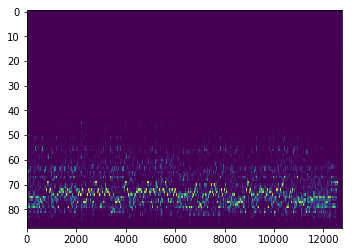

In [28]:
fbanks.shape
plt.imshow(fbanks, aspect=100)